# Analyse factorielle des correspondances: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )



In [4]:
pip install itables


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install fanalysis


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



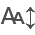

In [6]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats
from fanalysis.ca import CA 

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [7]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [8]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [9]:
## define SPARQL enpoint
endpoint = "https://ag1khc5dnlqgdc0c.allegrograph.cloud/repositories/Astronauts"

In [10]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/projhistoire/Projet-Histoire/blob/main/Wikidata/graph/imported-data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        OPTIONAL {
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))}
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        
          }
}
GROUP BY ?s
"""

In [11]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [12]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

867


[['http://www.wikidata.org/entity/Q118185981',
  'Anastasia Lenkova',
  '1995',
  'female',
  'Belarus',
  'Europe',
  '',
  ''],
 ['http://www.wikidata.org/entity/Q268912',
  'Mary Ellen Weber',
  '1962',
  'female',
  'United States',
  'North America',
  '',
  ''],
 ['http://www.wikidata.org/entity/Q56725368',
  'Hazza Al Mansouri',
  '1983',
  'male',
  'United Arab Emirates',
  'Asia',
  '',
  '']]

In [13]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,


In [14]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [15]:
### Verify if there's just one row per person
cf_pc = pd.DataFrame(df_p.groupby('personUri').size())
# cf_pc.reset_index(inplace=True)
cf_pc.columns = ['number']
cf_pc.sort_values('number', ascending=False).head(3)

,number
personUri,
http://www.wikidata.org/entity/Q995007,1
http://www.wikidata.org/entity/Q1009884,1
http://www.wikidata.org/entity/Q1018622,1


In [16]:
### Store to CSV if you want to avoid repeating the query:
# you can then juste reload the data
f_path = 'data/df_continent_occupations_fields_20250413.csv'


In [17]:
### Store
df_p.to_csv(f_path)

In [18]:
### Read
# df_p = pd.read_csv(f_path, index_col=0)


In [19]:
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,


In [20]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    867 non-null    object
 1   personLabel  867 non-null    object
 2   birthYear    867 non-null    int64 
 3   gender       867 non-null    object
 4   countries    867 non-null    object
 5   continents   867 non-null    object
 6   occupations  867 non-null    object
 7   fields       867 non-null    object
dtypes: int64(1), object(7)
memory usage: 54.3+ KB


## Coder les continents et afficher leur distribution

In [21]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0           Europe
1    North America
2             Asia
3             Asia
4           Europe
Name: continents, dtype: object


In [22]:
df_p.continents = df_p.continents.apply(lambda x : str(x))

In [23]:
def split_strip_sort (x):
    a = x.split(',')
    b = sorted([e.strip() for e in a])
    c = ','.join(b)
    return c



In [24]:
print(split_strip_sort('Asia, North America, Eurasia'))

Asia,Eurasia,North America


In [25]:
print(split_strip_sort('Asia'))

Asia


In [26]:
print(df_p.groupby(by='continents').size().sort_values(ascending=False))

continents
North America                           448
Europe                                  171
Asia, Europe                            128
Asia                                     81
North America, Europe                    12
North America, Asia                       5
North America, Eurasia, Asia, Europe      4
North America, Oceania                    3
South America                             3
Africa                                    2
Europe, Asia                              2
Oceania                                   2
Asia, Africa                              1
Europe, Africa                            1
North America, Africa                     1
Europe, Eurasia                           1
Oceania, Europe                           1
South America, North America              1
dtype: int64


In [27]:
## Mettre les pays en order alphabétique
df_p.continents = df_p['continents'].apply(lambda x: split_strip_sort(x))
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,


In [28]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                                     0
continents                            
North America                      448
Europe                             171
Asia,Europe                        130
Asia                                81
Europe,North America                12
Asia,North America                   5
Asia,Eurasia,Europe,North America    4
South America                        3
North America,Oceania                3
Africa                               2


In [29]:
## Mettre les pays en order alphabétique
df_p.countries = df_p.countries.apply(lambda x: split_strip_sort(x))
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,


In [30]:
### Regrouper et compter
df_countriesCode = df_p.groupby('countries').size()
df_countriesCode.columns=['effectif']
df_countriesCode = pd.DataFrame(df_countriesCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_countriesCode.iloc[:40])



                                      0
countries                              
United States                       427
Russia,Soviet Union                  85
Russia                               69
Soviet Union                         31
People's Republic of China           29
Japan                                17
Canada                               14
Germany                              13
France                               11
Italy                                10
United Kingdom                        7
Saudi Arabia                          7
India                                 5
Belgium                               5
Spain                                 5
United Kingdom,United States          4
Hungary                               4
Czech Republic                        4
United Arab Emirates                  4
Bulgaria                              3
Austria                               3
Australia,United States               3
Poland                                3


In [31]:
### How to code the continent of Russians
df_p[df_p.countries.str.contains('Russi')].sort_values(by='birthYear').tail(10)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
862,http://www.wikidata.org/entity/Q50379072,Nikolay Chub,1984,male,Russia,Europe,,
607,http://www.wikidata.org/entity/Q109493060,Konstantin Borisov,1984,male,Russia,Europe,,
551,http://www.wikidata.org/entity/Q18352451,Anna Kikina,1984,female,"Russia,Soviet Union","Asia,Europe",,
781,http://www.wikidata.org/entity/Q21856852,Ivan Vagner,1985,male,Russia,Europe,,
126,http://www.wikidata.org/entity/Q109490108,Oleg Platonov,1986,male,Russia,Europe,,
165,http://www.wikidata.org/entity/Q109490152,Q109490152,1986,male,Russia,Europe,,
213,http://www.wikidata.org/entity/Q118114238,Sergej Teterjatnikov,1988,male,Russia,Europe,,
640,http://www.wikidata.org/entity/Q109493064,Aleksandr Gorbunov,1990,male,Russia,Europe,,
395,http://www.wikidata.org/entity/Q109491455,Kirill Peskov,1990,male,Russia,Europe,,
757,http://www.wikidata.org/entity/Q109490367,Alexey Zubritsky,1992,male,"Russia,Ukraine",Europe,,


In [32]:
### 
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
97,http://www.wikidata.org/entity/Q472491,Gennadi Sarafanov,1942,male,Soviet Union,"Asia,Europe",,
98,http://www.wikidata.org/entity/Q74015,Dorothy M. Metcalf-Lindenburger,1975,female,United States,North America,,
99,http://www.wikidata.org/entity/Q29618,Bonnie J. Dunbar,1949,female,United States,North America,,
100,http://www.wikidata.org/entity/Q728371,Vasily Tsibliyev,1954,male,Russia,Europe,,


In [33]:
# Noter la personne index 116, František Doutlík trouvé grâce à la propriété 'field'
df_p.iloc[ 111:118 :  ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
111,http://www.wikidata.org/entity/Q528943,Guion Bluford,1942,male,United States,North America,,
112,http://www.wikidata.org/entity/Q318934,Joseph M. Acaba,1967,male,United States,North America,,
113,http://www.wikidata.org/entity/Q28540326,Matthias Maurer,1970,male,Germany,Europe,,
114,http://www.wikidata.org/entity/Q63594,Bùi Thanh Liêm,1949,male,Vietnam,Asia,,
115,http://www.wikidata.org/entity/Q41632,Marsha Ivins,1951,female,United States,North America,,
116,http://www.wikidata.org/entity/Q29650,Charles O. Hobaugh,1961,male,United States,North America,,
117,http://www.wikidata.org/entity/Q265261,Janet L. Kavandi,1959,female,United States,North America,,


In [34]:
### Personnes trouvées grâce à leur champ, 'field'
# https://stackoverflow.com/questions/21055068/reversal-of-string-contains-in-python-pandas
dff = df_p[~(df_p.occupations.str.contains("astronomer|physicist"))]
print('Effectif: ', len(dff), '\n')
print(dff.head(2).personUri)
dff.head()

Effectif:  867 

0    http://www.wikidata.org/entity/Q118185981
1       http://www.wikidata.org/entity/Q268912
Name: personUri, dtype: object


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,


In [35]:
### Problème du contienent d'appartenance des russes,
# commetn coder?
dfr = df_p[df_p.countries.str.contains('Russi|Sovi')]
print(len(dfr))

206


In [36]:
show(dfr,  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", 
     columnDefs=[{"className": "dt-left", "targets": "_all"}],
     search={"regex": True, "caseInsensitive": True},
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading ITables v2.3.0 from the init_notebook_mode cell... (need help?)


In [37]:
dfea = df_p[df_p.continents.str.contains('Euras')]
print(len(dfea))

5


In [38]:
show(dfea,  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", 
     columnDefs=[{"className": "dt-left", "targets": "_all"}],
     search={"regex": True, "caseInsensitive": True},
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading ITables v2.3.0 from the init_notebook_mode cell... (need help?)


In [39]:
### Créer une fonction de codage
def codeContinents(continents, countries):
    
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    if 'ussi' in countries or 'oviet' in countries:
        output = 'Eurasia'
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'Asia,Europe' in continents:
        output = 'Eurasia'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [40]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents'], x['countries']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia


In [41]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode)
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode.sort_values('effectif',ascending = False))



              effectif
contCode              
NorthAmerica       449
Eurasia            208
Europe             110
Asia                86
Oceania              6
Africa               5
SouthAmerica         3


In [42]:
 
### Regrouper et compter les personnes issues de Russie
# le codage 
df_contCode = df_p[df_p.countries.str.contains('ussi|oviet')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia        206


In [43]:
df_p[(df_p.countries.str.contains('ussi|oviet')) & (df_p.contCode.str.contains('Europe'))].head(10)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode


### Continents: codage par période de vingt-cinq ans

In [44]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1900, 2050, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1900, 1925, 1950, 1975, 2000] [1925, 1950, 1975, 2000, 2025] 5


In [45]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [46]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999


In [47]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1900-1924     34
1925-1949    311
1950-1974    386
1975-1999    133
2000-2024      3
dtype: int64


## Analyse bivariée: périodes, continents

In [48]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1900-1924,9,14,11,0,0,0,0,34
1925-1949,30,97,172,9,1,2,0,311
1950-1974,46,71,224,37,3,2,3,386
1975-1999,25,26,41,38,1,2,0,133
2000-2024,0,0,1,2,0,0,0,3
Total,110,208,449,86,5,6,3,867


In [49]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


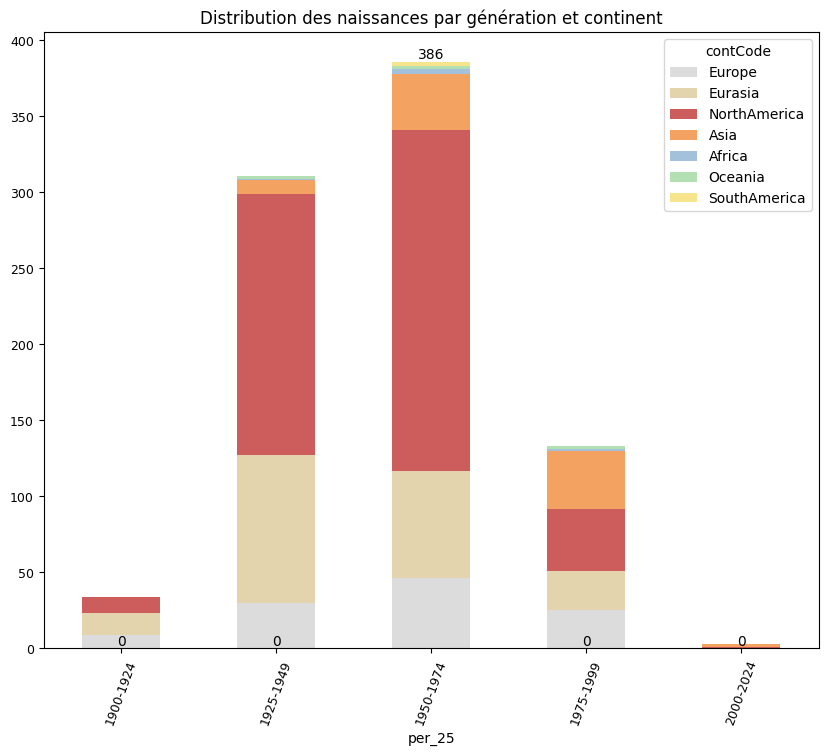

In [50]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), 
                     color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

# Enregistrer le graphique dans le dossier images
plt.savefig('images/distribution_naissances_par_continent.png', 
            bbox_inches='tight', dpi=300)

plt.show()

### Créer les fonctions

In [51]:
### ct_m : contingency table without totals in margins
def bivariee_stats(ct_wm):
    
    
    n = ct_wm.sum().sum()

    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(ct_wm)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)

    

    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(ct_wm, method='cramer')
    print('Cramer: ', vc)

    return None





In [52]:
ct_wm = ddf.iloc[:-1,:-1].copy(deep=True)
ct_wm

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1900-1924,9,14,11,0,0,0,0
1925-1949,30,97,172,9,1,2,0
1950-1974,46,71,224,37,3,2,3
1975-1999,25,26,41,38,1,2,0
2000-2024,0,0,1,2,0,0,0


In [53]:
bivariee_stats(ct_wm)

Chi2 : 128.82 , dof : 24
p-value : 2.535261824612151e-16
phi2 = inertie (variance totale) : 0.14858214215929175
Cramer:  0.1927317709663431


In [54]:
### ct_m : contingency tables with totals in margins
def plot_chi2_residuals(ct_wm, figsize=(9,3)):
    
    D = ct_wm

    
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
   

    fig, ax = plt.subplots(figsize=figsize)         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    py = g.set_yticklabels(ylabels, rotation=20, size=8)
    
    plt.show()

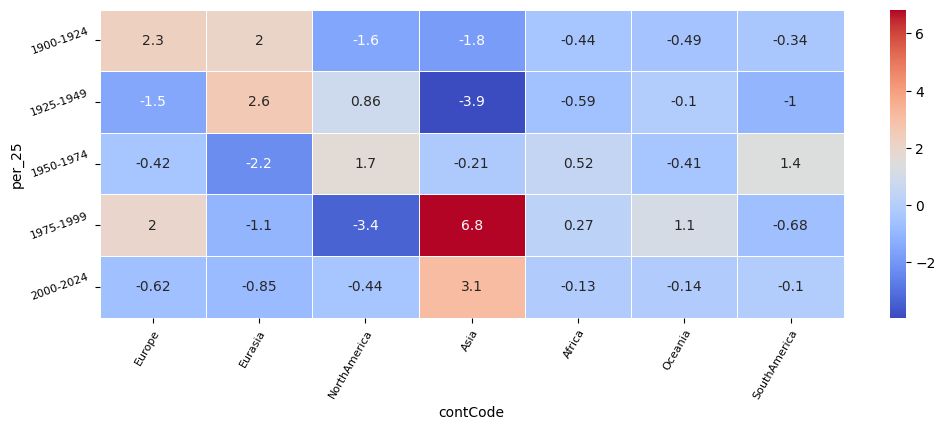

In [55]:
pp = plot_chi2_residuals(ct_wm, figsize=(12, 4))


### Analyse factorielle des correspondances (AFC)

In [56]:
ct_wm

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1900-1924,9,14,11,0,0,0,0
1925-1949,30,97,172,9,1,2,0
1950-1974,46,71,224,37,3,2,3
1975-1999,25,26,41,38,1,2,0
2000-2024,0,0,1,2,0,0,0


In [57]:
afc = CA(row_labels=ct_wm.index,col_labels=ct_wm.columns)
afc.fit(ct_wm.values)

CA(col_labels=Index(['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania',
       'SouthAmerica'],
      dtype='object', name='contCode'),
   row_labels=Index(['1900-1924', '1925-1949', '1950-1974', '1975-1999', '2000-2024'], dtype='object', name='per_25'))

In [58]:
def print_eigenvalue(afc):

    eig = pd.DataFrame(afc.eig_)

    r1 = round(eig.iloc[0], 3)
    r2 = round(eig.iloc[2], 2)
    s=list(range(1,len(r1)+1))
    r1.index=s
    r2.index=s

    # https://www.statology.org/pandas-subplots/
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
    ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


    ax1.bar_label(ax1.containers[0])
    ax2.bar_label(ax2.containers[0])


    # Met les valeurs xticks en vertical
    fig.autofmt_xdate(rotation=0)
    plt.show()

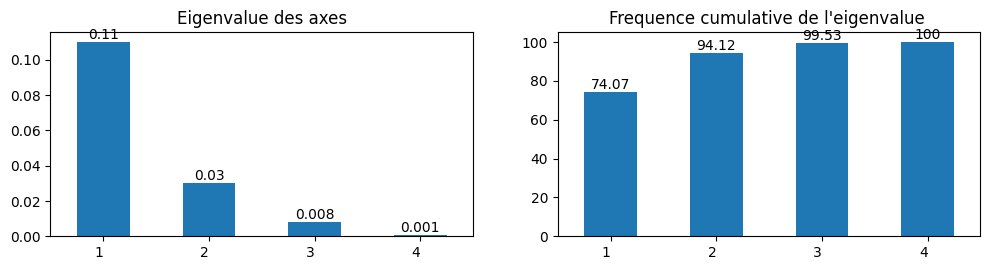

In [59]:
print_eigenvalue(afc)

In [60]:
def contributions_colonnes(afc):
    
    # Informations sur les contributions des colonnes
    df = afc.col_topandas()[['col_contrib_dim1',
                            'col_contrib_dim2',
                            'col_contrib_dim3']]

    r1 = df.iloc[:,0]
    r2 = df.iloc[:,1]
    r3 = df.iloc[:,2]

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

    r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
    r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
    r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

    ### Rows
    df = afc.row_topandas()[['row_contrib_dim1',
                            'row_contrib_dim2',
                            'row_contrib_dim3']]
    r1 = df.iloc[:,0]
    r2 = df.iloc[:,1]
    r3 = df.iloc[:,2]

    r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
    r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
    r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

    plt.tight_layout()
    plt.show()


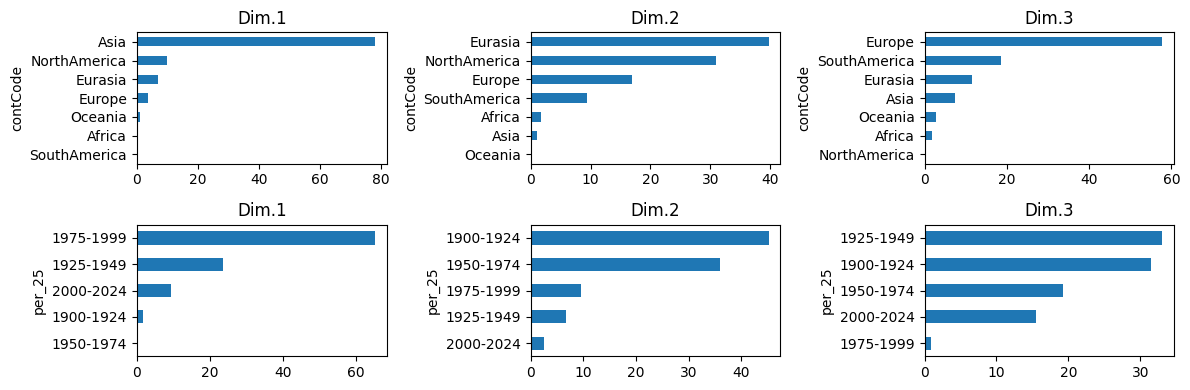

In [61]:
contributions_colonnes(afc)

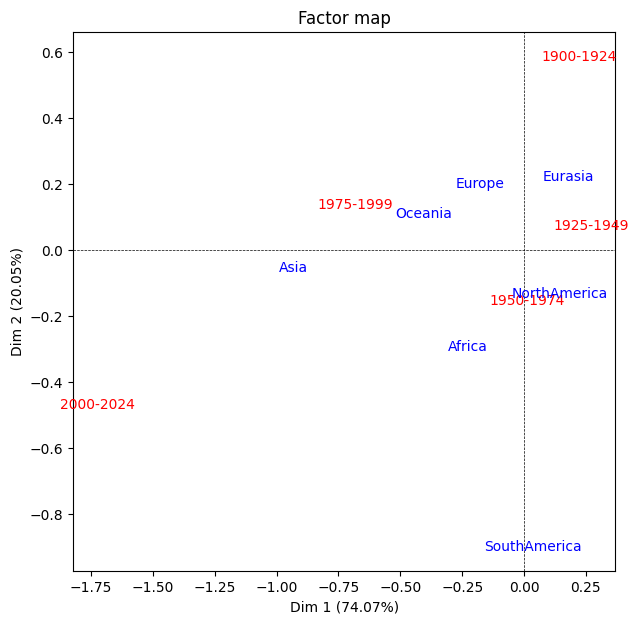

In [62]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

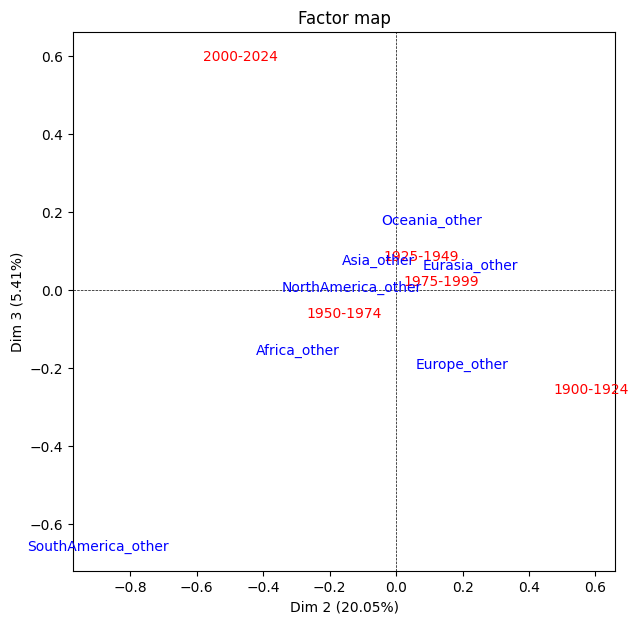

In [331]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))


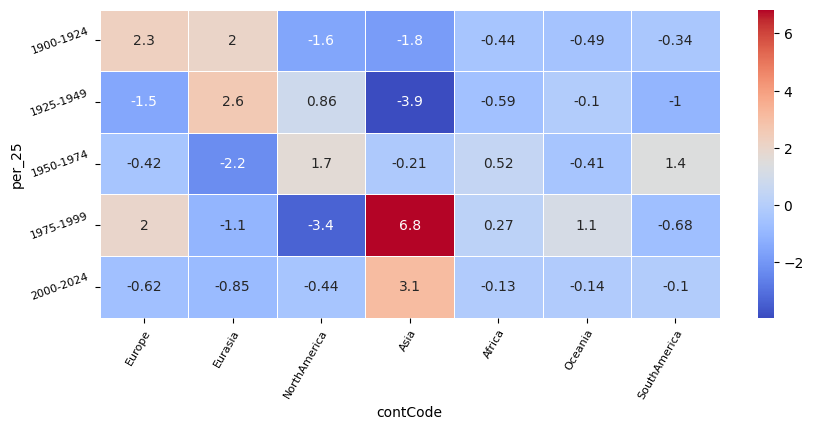

In [277]:
pp = plot_chi2_residuals(ct_wm, figsize=(10, 4))

## Continent et genre

In [63]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia,1950-1974
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe,1950-1974


In [64]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[(df_p.contCode!='Missing') & (df_p.gender.isin(['female', 'male']))]\
            [[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,0,17,13,15,71,1,0,117
male,5,69,195,95,378,5,3,750
Total,5,86,208,110,449,6,3,867


### Genre et continent par époque

In [65]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999,Asia_male
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia,1950-1974,Asia_male
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe,1950-1974,Europe_female


In [66]:


### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[(df_p.contCode!='Missing') & (df_p.gender.isin(['female', 'male']))]\
                [[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp



genre_cont,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,
1900-1924,0,0,0,0,14,0,9,0,11,0,0,0,34
1925-1949,1,0,9,8,89,0,30,11,161,0,2,0,311
1950-1974,3,7,30,3,68,4,42,41,183,0,2,3,386
1975-1999,1,10,28,2,24,11,14,19,22,1,1,0,133
2000-2024,0,0,2,0,0,0,0,0,1,0,0,0,3
Total,5,17,69,13,195,15,95,71,378,1,5,3,867


In [67]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[:-1,:-1].copy(deep=True)
D


genre_cont,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_male
per_25,,,,,,,,,,,,
1900-1924,0,0,0,0,14,0,9,0,11,0,0,0
1925-1949,1,0,9,8,89,0,30,11,161,0,2,0
1950-1974,3,7,30,3,68,4,42,41,183,0,2,3
1975-1999,1,10,28,2,24,11,14,19,22,1,1,0
2000-2024,0,0,2,0,0,0,0,0,1,0,0,0


In [68]:
### Exclure l'Afrique
D = ddgcp.iloc[:-1,:-1].copy(deep=True)
D


genre_cont,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_male
per_25,,,,,,,,,,,,
1900-1924,0,0,0,0,14,0,9,0,11,0,0,0
1925-1949,1,0,9,8,89,0,30,11,161,0,2,0
1950-1974,3,7,30,3,68,4,42,41,183,0,2,3
1975-1999,1,10,28,2,24,11,14,19,22,1,1,0
2000-2024,0,0,2,0,0,0,0,0,1,0,0,0


In [69]:
## Appliquer la fonction
bivariee_stats(D)

Chi2 : 211.18 , dof : 44
p-value : 1.060049434823261e-23
phi2 = inertie (variance totale) : 0.24357767024832938
Cramer:  0.24676794273584715


### AFC

In [70]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['Africa_male', 'Asia_female', 'Asia_male', 'Eurasia_female',
       'Eurasia_male', 'Europe_female', 'Europe_male', 'NorthAmerica_female',
       'NorthAmerica_male', 'Oceania_female', 'Oceania_male',
       'SouthAmerica_male'],
      dtype='object', name='genre_cont'),
   row_labels=Index(['1900-1924', '1925-1949', '1950-1974', '1975-1999', '2000-2024'], dtype='object', name='per_25'))

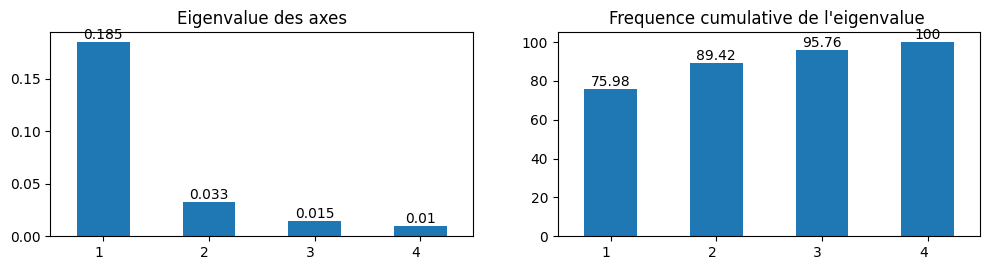

In [71]:
print_eigenvalue(afc)

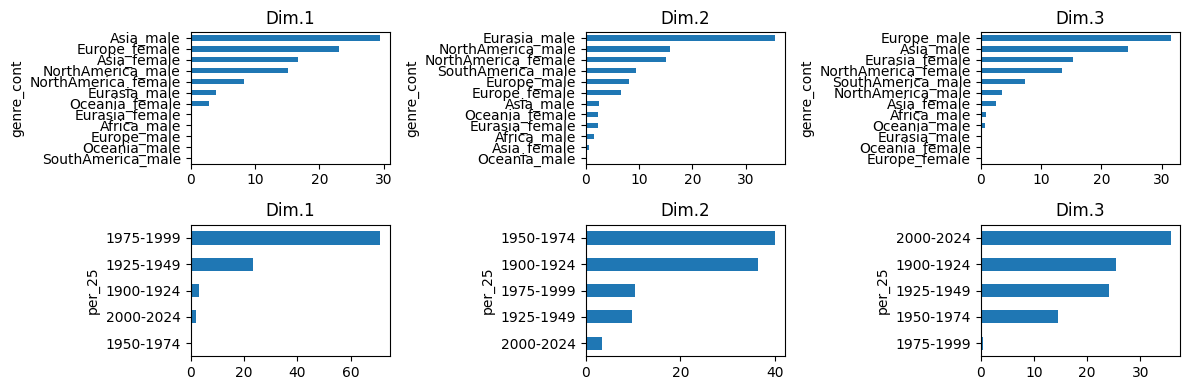

In [72]:
contributions_colonnes(afc)

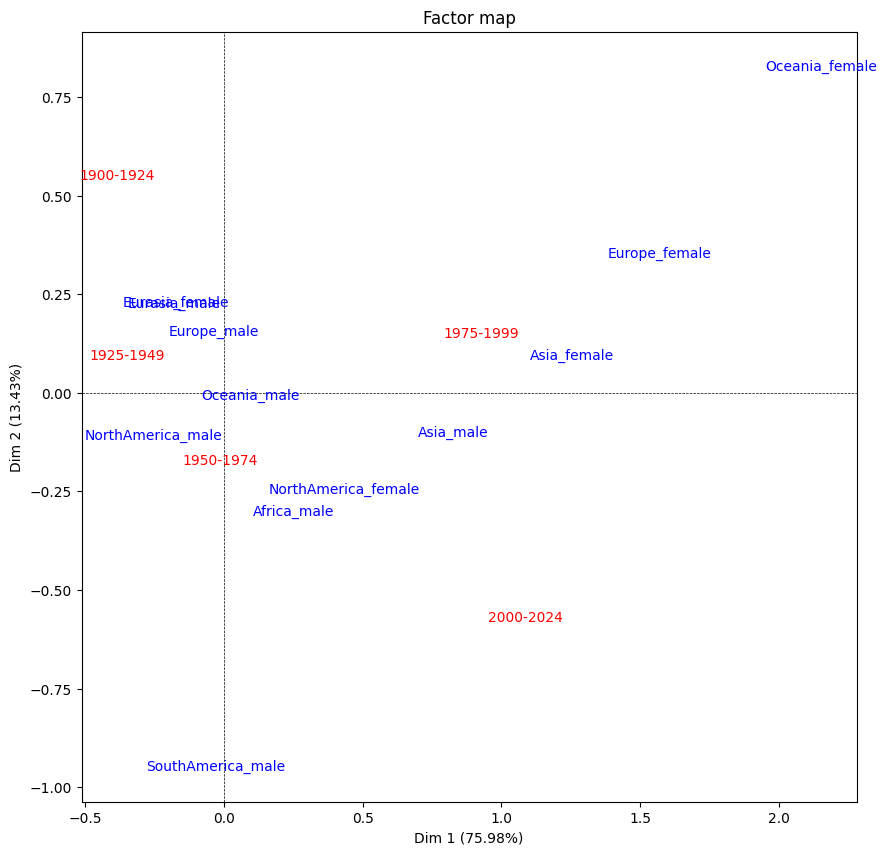

In [73]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))

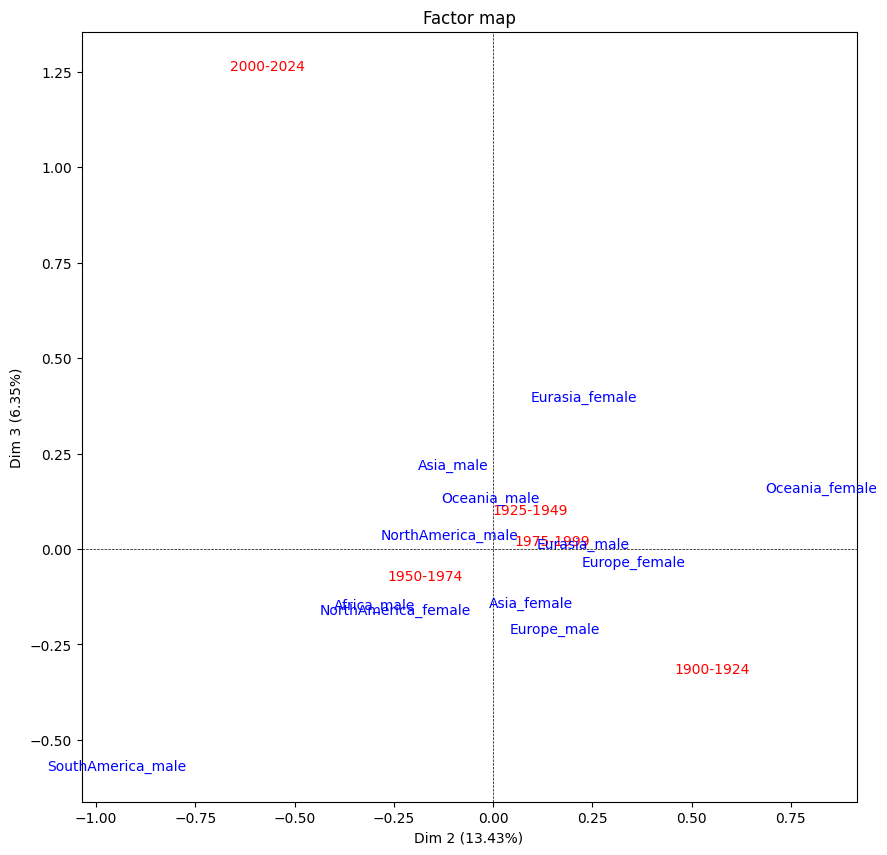

In [74]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(10,10))

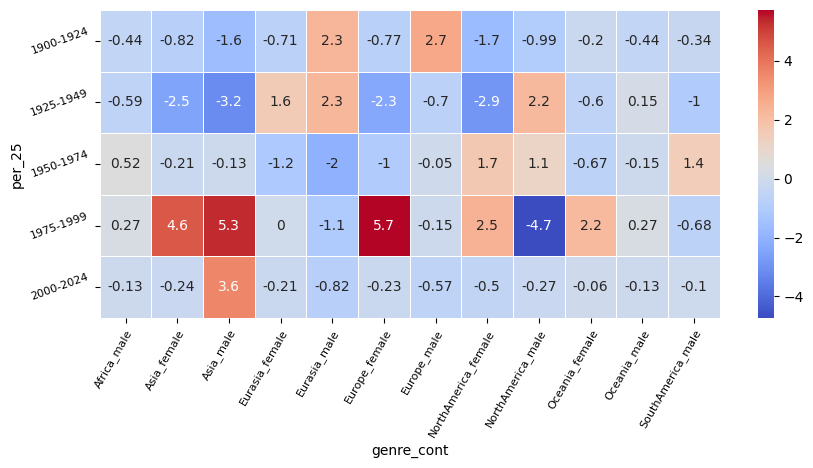

In [75]:
pp = plot_chi2_residuals(D, figsize=(10, 4))

## Continent et discipline

In [294]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999,Asia_male
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia,1950-1974,Asia_male
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe,1950-1974,Europe_female


In [295]:
def code_discipline(col1, col2):
    if  'astronomer' in col1\
        or 'astronomy' in col2:
        output = 'astronomy'
    elif 'physicist' in col1\
        or 'physics' in col2:
        output = 'physics'
    else:
        output = 'other'
    return output    


In [296]:
df_p['code_discipline'] = df_p.apply(lambda x: code_discipline(x.occupations, x.fields), axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female,other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female,other
2,http://www.wikidata.org/entity/Q56725368,Hazza Al Mansouri,1983,male,United Arab Emirates,Asia,,,Asia,1975-1999,Asia_male,other
3,http://www.wikidata.org/entity/Q197135,Zhai Zhigang,1966,male,People's Republic of China,Asia,,,Asia,1950-1974,Asia_male,other
4,http://www.wikidata.org/entity/Q235580,Claudie Haigneré,1957,female,France,Europe,,,Europe,1950-1974,Europe_female,other


In [297]:
df_p.groupby('code_discipline').size()

code_discipline
other    867
dtype: int64

In [298]:


### Tableau de contingence
X = "contCode"
Y = "code_discipline"  # "0"

dddc = df_p[(df_p.contCode!='Missing') & (df_p.gender.isin(['female', 'male']))]\
        [[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
other,5,86,208,110,449,6,3,867
Total,5,86,208,110,449,6,3,867


In [299]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
code_discipline,,,,,,,,
other,0.6,9.9,24.0,12.7,51.8,0.7,0.3,100.0
Total,0.6,9.9,24.0,12.7,51.8,0.7,0.3,100.0


In [300]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


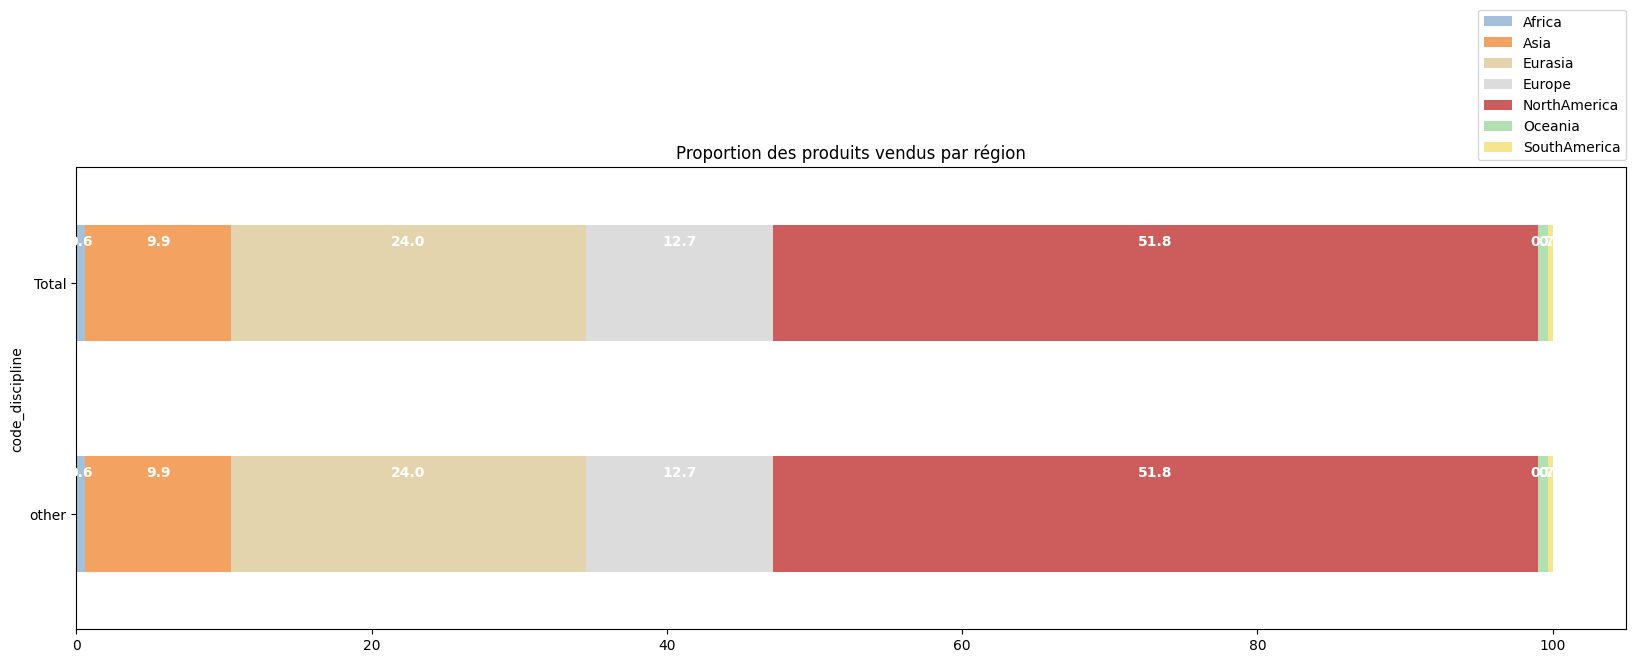

In [301]:


### https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

ax = dddc_pl.iloc[:, :-1].sort_index(ascending=False).plot(kind="barh",
                    stacked=True, figsize=(20,6), title='Proportion des produits vendus par région',
                    color=col_palette_2
                    )

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots

for p in ax.patches:
    b = p.get_bbox()
    y_value=b.y1-b.y0
    ax.annotate(format(p.get_width(), '.1f'), 
                   (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   # style = 'italic',
                   weight='bold',
                   color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

ax.legend(bbox_to_anchor=(0.9, 1))

plt.show()

In [304]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
code_discipline,,,,,,,
other,5,86,208,110,449,6,3


In [305]:
## Appliquer la fonction
bivariee_stats(D)

AttributeError: 'float' object has no attribute 'round'

## Discipline et continent par époque

In [306]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female,other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female,other


In [307]:
df_p['disc_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.code_discipline, axis=1)
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont,code_discipline,disc_cont
0,http://www.wikidata.org/entity/Q118185981,Anastasia Lenkova,1995,female,Belarus,Europe,,,Europe,1975-1999,Europe_female,other,Europe_other
1,http://www.wikidata.org/entity/Q268912,Mary Ellen Weber,1962,female,United States,North America,,,NorthAmerica,1950-1974,NorthAmerica_female,other,NorthAmerica_other


In [308]:
### Tableau de contingence
X = "disc_cont"
Y = "per_25"  # "0"

dddcp = df_p[(df_p.contCode!='Missing') & (df_p.gender.isin(['female', 'male']))]\
            [[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddcp

disc_cont,Africa_other,Asia_other,Eurasia_other,Europe_other,NorthAmerica_other,Oceania_other,SouthAmerica_other,Total
per_25,,,,,,,,
1900-1924,0,0,14,9,11,0,0,34
1925-1949,1,9,97,30,172,2,0,311
1950-1974,3,37,71,46,224,2,3,386
1975-1999,1,38,26,25,41,2,0,133
2000-2024,0,2,0,0,1,0,0,3
Total,5,86,208,110,449,6,3,867


In [311]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[:-1,:-1].copy(deep=True)
D


disc_cont,Africa_other,Asia_other,Eurasia_other,Europe_other,NorthAmerica_other,Oceania_other,SouthAmerica_other
per_25,,,,,,,
1900-1924,0,0,14,9,11,0,0
1925-1949,1,9,97,30,172,2,0
1950-1974,3,37,71,46,224,2,3
1975-1999,1,38,26,25,41,2,0
2000-2024,0,2,0,0,1,0,0


In [312]:
## Appliquer la fonction
bivariee_stats(D)

Chi2 : 128.82 , dof : 24
p-value : 2.535261824612151e-16
phi2 = inertie (variance totale) : 0.14858214215929175
Cramer:  0.1927317709663431


### AFC

In [313]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['Africa_other', 'Asia_other', 'Eurasia_other', 'Europe_other',
       'NorthAmerica_other', 'Oceania_other', 'SouthAmerica_other'],
      dtype='object', name='disc_cont'),
   row_labels=Index(['1900-1924', '1925-1949', '1950-1974', '1975-1999', '2000-2024'], dtype='object', name='per_25'))

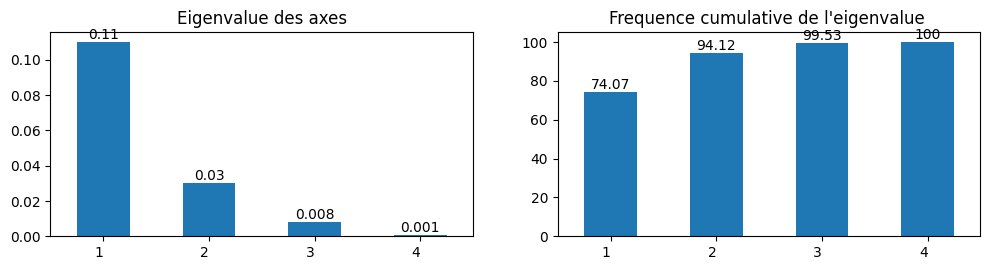

In [314]:
print_eigenvalue(afc)

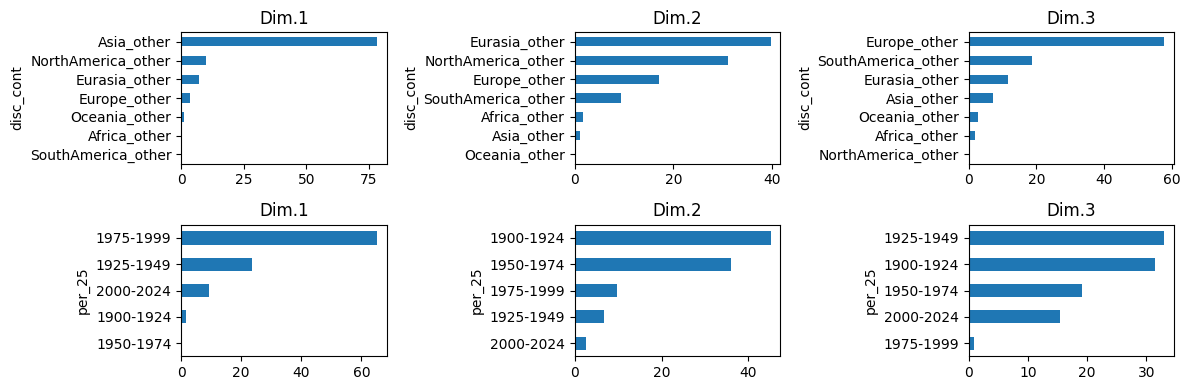

In [315]:
contributions_colonnes(afc)

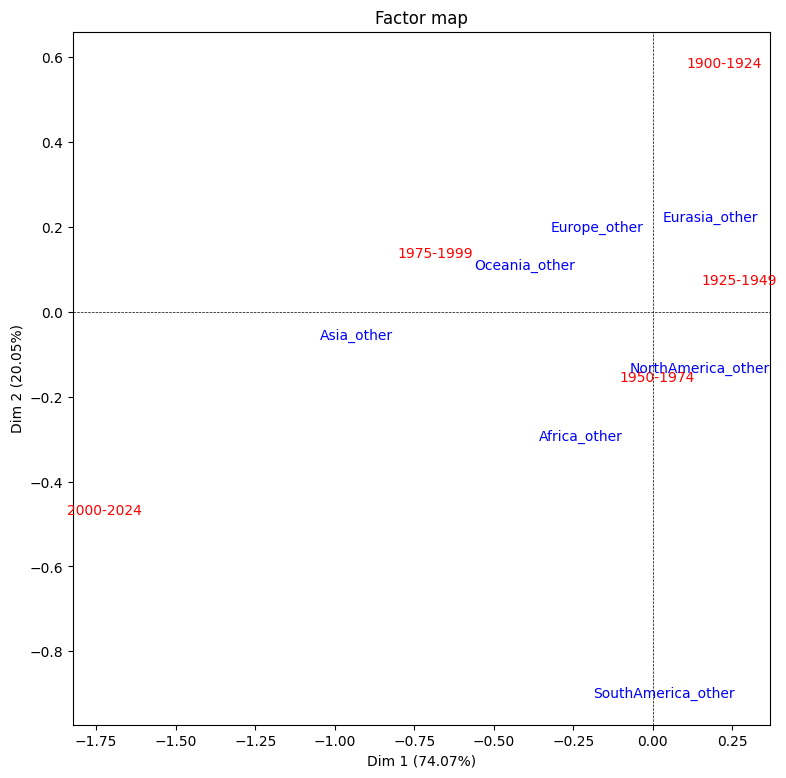

In [316]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(9,9))

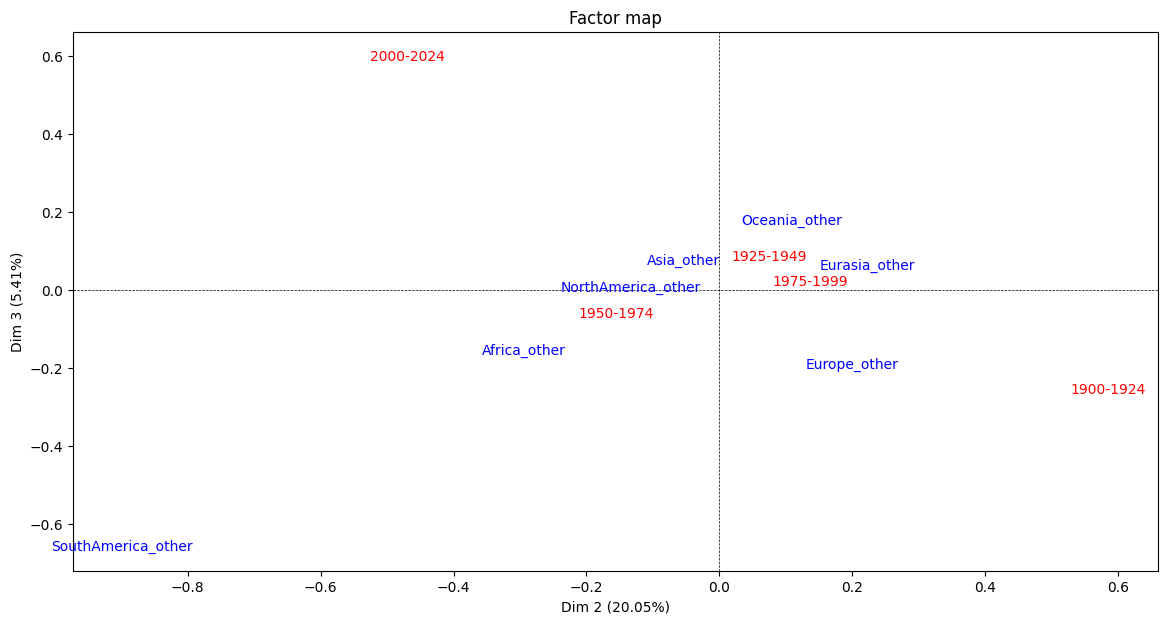

In [317]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(14,7))

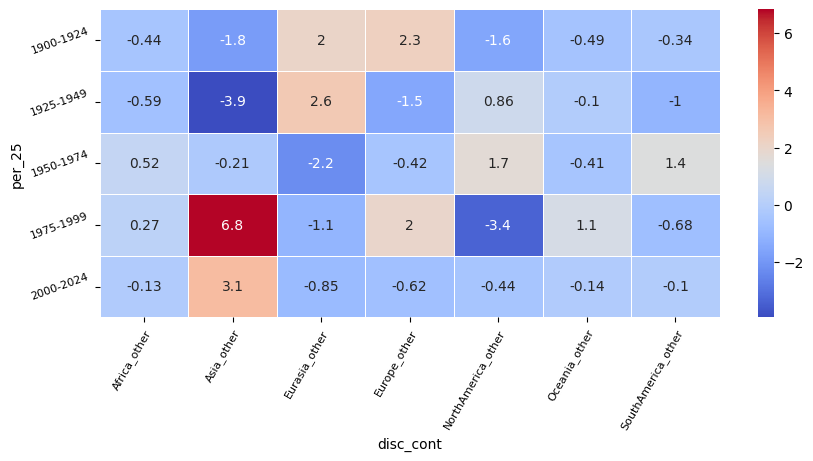

In [318]:
pp = plot_chi2_residuals(D, figsize=(10, 4))